In [28]:
import sys
sys.path.append("/home/diego/python/convolution-kernels/")
sys.path.append("/home/diego/python/stochastic-processes/")
sys.path.append("/home/diego/python/utils/")

import matplotlib.pyplot as plt
import numpy as np

from kernel.fun import KernelFun
from processes.renewal_process import RenewalProcess
# from processes.gaussian_process import GaussianProcess
from processes.dichotomized_gaussian import DichotomizedGaussian
from signals import raw_autocorrelation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


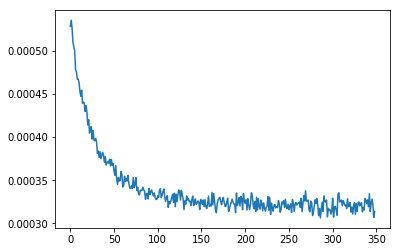

In [94]:
def double_exp(t, A, tr, td, t0):
    return A * tr * td / (td - tr) * (np.exp(-(t - t0) / td) - np.exp(-(t - t0) / tr))

n_trials = 10000
t = np.arange(0, 1000, 1)

b, A, tr, td, t0 = -4.5, 0.2, 5, 50, 12
t0 = 0

# eta = KernelFun(double_exp, basis_kwargs=dict(A=np.array([A])), shared_kwargs=dict(tr=tr, td=td, t0=t0), 
#             coefs=np.array([1]), support=[0, tr * td / (td - tr) + td * 7])
eta = KernelFun(lambda t, A, td: A * np.exp(-t / td), basis_kwargs=dict(A=np.array([1])), 
                shared_kwargs=dict(td=td), 
              coefs=np.array([1]), support=[0, td * 7])
rp = RenewalProcess(b, eta)

u, r, mask_spikes = rp.sample(t, shape=(n_trials,))
n_spikes = np.sum(mask_spikes, 0)
raw_autocor = np.mean(raw_autocorrelation(mask_spikes, biased=False), 1)

lam = np.mean(n_spikes) / (len(t) * 1)

fig, ax1 = plt.subplots()
ax1.plot(raw_autocor[1:350])

In [113]:
from scipy.special import erfinv
from scipy.stats import multivariate_normal
from processes.gaussian_process import GaussianProcess

from sptr.sptr import SpikeTrain

cov0 = 2
p = np.mean(n_spikes) / len(t)
mu = np.log(p) - cov0 / 2
drho = 1e-3
# rho_gauss = np.arange(-1 + drho, 1, drho)
rho_gauss = np.log(raw_autocor[:250]) / cov0 - 2 * mu / cov0 - 1

autocov = cov0 * rho_gauss
autocov[0] = cov0

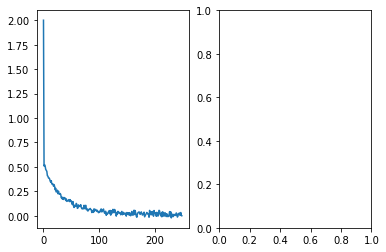

In [114]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(autocov)

# plt.plot(autocov)
# plt.plot(error_rho)
# plt.plot(raw_autocor[1:250])
# plt.plot(raw_autocorr_dg)

-5.0281414093832755 1.9992234132229223 -5.027871663200361 2
17.8122 17.6956


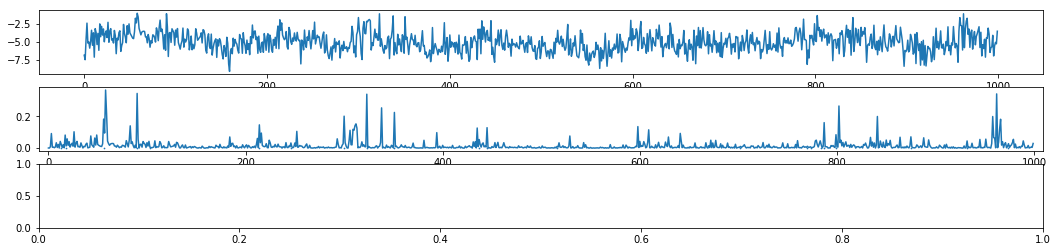

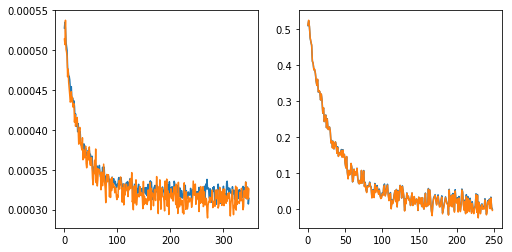

In [115]:
# autocov = 4e0 * np.exp(-np.arange(0, len(autocov), 1) / 20)
gp = GaussianProcess(mu=mu, autocov=autocov)
gp.set_t(t)

u = gp.sample(shape=(5000,))
x = np.exp(u) > np.random.rand(*u.shape)
gp_autocorr = np.mean(raw_autocorrelation(u, biased=False), 1) - mu**2
raw_autocor2 = np.mean(raw_autocorrelation(x, biased=False), 1) 

print(np.mean(u), np.mean((u - mu)**2), mu, cov0)
print(np.mean(np.sum(mask_spikes, 0)),  np.mean(np.sum(x, 0)))

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 4), nrows=3)
ax1.plot(u[:, 0])
ax2.plot(np.exp(u[:, 0]))
SpikeTrain(t, x[:, :1]).plot(ax=ax2, ms=0.7)

fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
ax1.plot(raw_autocor[1:350])
ax1.plot(raw_autocor2[1:350])
# ax1.set_ylim(-1e-5, 4e-4)
# ax1.set_ylim(3e-4, 1e-3)
ax2.plot(autocov[1:250])
ax2.plot(gp_autocorr[1:250])

In [257]:
raw_autocor[0], raw_autocor2[0]

(0.017821999999999998, 0.0177516)

In [48]:
import numpy as np
from scipy.special import erfinv

# from .utils import get_dt

def get_dt(t):
    arg_dt = 20 if len(t) >= 20 else len(t)
    dt = np.mean(np.diff(t[:arg_dt]))
    return dt

class DichotomizedGaussian:
    """Sample stationary spike trains using the Dichotomized Gaussian (Macke et al 2009).

    Attributes:
        lam (str): Baseline firing rate
        attr2 (:obj:`int`, optional): Description of `attr2`.

    """
    def __init__(self, lam=0, raw_autocorrelation=1, drho=1e-3):
        self.lam = lam
        self.raw_autocorrelation = raw_autocorrelation
        
        self.mu = np.sqrt(2) * erfinv(2 * p - 1)
        
        rho_gauss = np.arange(-1 + drho, 1, drho)

        rho_dg = []
        for _rho_gauss in rho_gauss:
            cov_gauss = np.array([[1, _rho_gauss], [_rho_gauss, 1]])
            rho_dg.append(1 + multivariate_normal.cdf([0, 0], mean=np.ones(2) * mu, cov=cov_gauss) - \
                          2 * multivariate_normal.cdf([0], mean=np.ones(1) * mu, cov=np.array([1])))
        rho_dg = np.array(rho_dg)
        
        self.autocov = rho_gauss[np.argmin((raw_autocorrelation - rho_dg[None, :])**2, 1)]
        self.autocov[0] = 1
        
        self.gp = GaussianProcess(mu=self.mu, autocov=self.autocov)

    def set_t(t)
#         self.t = t
        self.gp.set_t(t, inv_cov=False, cholesky=True)
        return self
    
    def sample(self, t=None, shape=(1,), seed=None):
        gp_samples = self.gp.sample(shape=shape, seed=seed)
        mask_spikes = gp_samples > 0
        return mask_spikes
    
    def sample2(self, t, shape=(1,), seed=None):
        """Sample spike trains.

        Args:
            t: 1d-array of time points
            shape: Output is a mask x with x.shape = (len(t),) + shape
            seed: sets numpy seed

        Returns:
            Boolean mask of spikes

        """
        np.random.seed(seed)
        
        dt = get_dt(t)
        
        p = self.lam * dt
        mu = np.sqrt(2) * erfinv(2 * p - 1)
        print(p, mu)
#         var = p * (1 - p)
        var = 1
        
        gaussian_samples = np.random.multivariate_normal(np.ones(len(t)) * mu, np.eye(len(t)) * var, size=shape).T
        print(gaussian_samples[:, 0])
        
        mask_spikes = gaussian_samples > 0
            
        return mask_spikes

In [58]:
dg = DichotomizedGaussian(lam=10)
t = np.arange(0, 2, 1e-3)

mask_spikes = dg.sample(t, shape=(100,))

0.01 -2.3263478740408408
[-2.30744134 -0.67529888 -0.38457111 ... -2.64873573 -1.94806413
 -3.10625501]


In [59]:
np.mean(np.sum(mask_spikes, 0))

19.96

In [19]:
p = 0.4
1 / 2 * (1 + erf(p / np.sqrt(2))), 1 / 2 * (1 + erf(-p / np.sqrt(2))), 1 - 1 / 2 * (1 + erf(p / np.sqrt(2)))

(0.6554217416103242, 0.3445782583896758, 0.3445782583896758)